## Basic information
#### frame of thickness is 0.084 mm


#### Read TIFF image stack

In [1]:
from PIL import Image
import numpy as np

# Read TIFF
img = Image.open("/Users/harrysong/Desktop/agriculture/tiff/020150.tiff")

frames = []
try:
    while True:
        frame = np.array(img.convert("L"))  # grayscale
        frames.append(frame)
        img.seek(img.tell() + 1)
except EOFError:
    pass  # End of file reached

print(f"total {len(frames)} frames")


total 2760 frames


#### 在每帧中检测圆形（麦秆）

In [2]:
import cv2
import numpy as np

def detect_stalk_circle(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # 提升对比度
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)
    
    # 高斯模糊（比中值模糊更适合平滑边缘）
    blurred = cv2.GaussianBlur(gray, (9, 9), 2)

    # 圆检测
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2,
                               minDist=20, param1=50, param2=20,
                               minRadius=15, maxRadius=35)
    
    if circles is not None:
        circles = np.uint16(np.around(circles))
        output = frame.copy()
        for i in circles[0, :]:
            # 可视化圆
            cv2.circle(output, (i[0], i[1]), i[2], (0, 255, 0), 2)
            cv2.circle(output, (i[0], i[1]), 2, (0, 0, 255), 3)
        cv2.imshow("Detected Circle", output)
        cv2.waitKey(0)
        return True
    return False


#### 找出麦秆开始和结束的帧

In [ ]:
start_frame = None
end_frame = None

for i, frame in enumerate(frames):
    # Convert grayscale frame to BGR (3-channel) for processing
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    
    if detect_stalk_circle(frame_rgb):
        if start_frame is None:
            start_frame = i
        end_frame = i  # 每次检测到都更新结束帧

if start_frame is not None and end_frame is not None:
    print(f"麦秆从第 {start_frame} 帧到第 {end_frame} 帧")
else:
    print("未检测到麦秆圆形")



#### 质心追踪

TIFF shape: (2760, 406, 416)
检测到的有效点数: 52
剔除的异常点数: 0
麦秆的估计长度: 183.69 mm


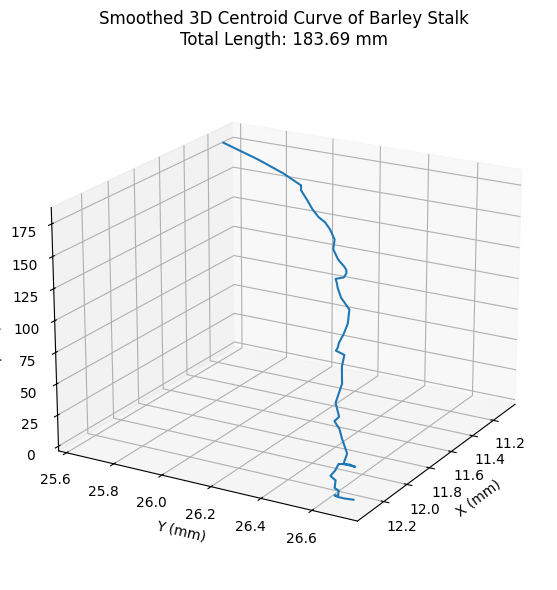

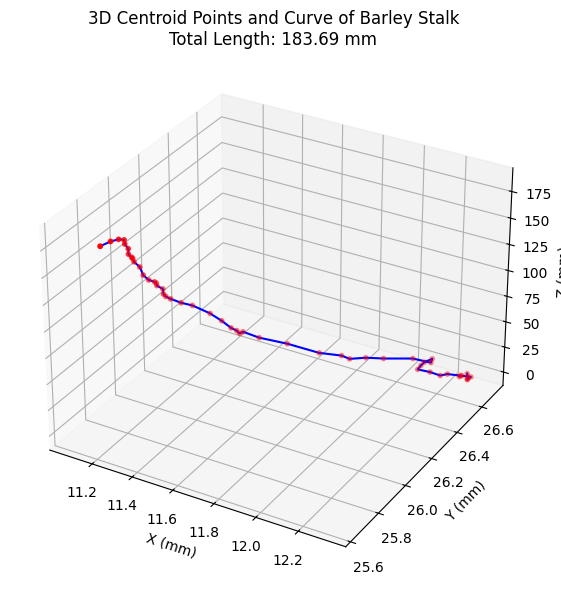

In [5]:
import cv2
import numpy as np
import tifffile
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from mpl_toolkits.mplot3d import Axes3D

# 参数
start_frame = 1496
end_frame = 2597
pixel_spacing = 0.084  # mm
z_spacing = 1.0  # CT 间距，单位 mm
min_area = 200  # 噪声面积过滤阈值（可调）

# 载入 tiff 图像堆栈
stack = tifffile.imread("/Users/harrysong/Desktop/agriculture/tiff/020150.tiff")
print(f"TIFF shape: {stack.shape}")  # (num_frames, H, W)

# 存储麦秆轨迹
centroids = []
areas = []  # 存储面积，用于异常检测

# 帧间最大位移限制（可调）
max_xy_displacement = 5  # 像素
last_valid_centroid = None

# 遍历所有帧
for i in range(start_frame, end_frame + 1):
    frame = stack[i]
    
    # CLAHE 增强
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(frame)
    
    # Gamma 校正（增强暗部对比度）
    gamma = 1.5
    gamma_corrected = np.power(enhanced / 255.0, gamma) * 255
    enhanced = gamma_corrected.astype(np.uint8)
    
    # 二值化
    _, binary = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # 轮廓提取
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # 面积过滤 + 质心提取
    valid = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
    
    if valid:
        # 如果有多个有效轮廓，可能需要使用历史信息选择最佳匹配
        if len(valid) > 1 and last_valid_centroid is not None:
            # 选择与上一个有效中心点最接近的轮廓
            closest_contour = None
            min_distance = float('inf')
            
            for cnt in valid:
                M = cv2.moments(cnt)
                if M["m00"] != 0:
                    cx = M["m10"] / M["m00"]
                    cy = M["m01"] / M["m00"]
                    dist = np.sqrt((cx - last_valid_centroid[0])**2 + (cy - last_valid_centroid[1])**2)
                    
                    if dist < min_distance and dist < max_xy_displacement:
                        min_distance = dist
                        closest_contour = cnt
            
            if closest_contour is not None:
                largest = closest_contour
            else:
                largest = max(valid, key=cv2.contourArea)
        else:
            largest = max(valid, key=cv2.contourArea)
        
        M = cv2.moments(largest)
        if M["m00"] != 0:
            cx = M["m10"] / M["m00"]
            cy = M["m01"] / M["m00"]
            cz = i - start_frame  # 注意：这里不应用z_spacing，留到单位转换时
            
            # 存储质心坐标和面积
            centroid = [cx, cy, cz]
            area = cv2.contourArea(largest)
            
            # 检查与上一个点的连续性
            if last_valid_centroid is not None:
                dx = cx - last_valid_centroid[0]
                dy = cy - last_valid_centroid[1]
                displacement = np.sqrt(dx**2 + dy**2)
                
                # 如果移动过大，可能是错误点
                if displacement <= max_xy_displacement:
                    centroids.append(centroid)
                    areas.append(area)
                    last_valid_centroid = centroid
            else:
                # 第一个有效点
                centroids.append(centroid)
                areas.append(area)
                last_valid_centroid = centroid

if not centroids:
    print("未检测到有效麦秆轨迹！")
    exit()

centroids = np.array(centroids)
areas = np.array(areas)

# 识别并剔除异常值 - 使用面积和位置的组合检测
mean_area = np.mean(areas)
std_area = np.std(areas)

valid_indices = []
for i in range(len(centroids)):
    # 检查面积是否在合理范围内
    if abs(areas[i] - mean_area) < 3 * std_area:  # 3倍标准差
        valid_indices.append(i)

centroids = centroids[valid_indices]
areas = areas[valid_indices]

print(f"检测到的有效点数: {len(centroids)}")
print(f"剔除的异常点数: {len(areas) - len(valid_indices)}")

# 平滑处理（可选）- 使用更小的窗口和更低的多项式阶数
if len(centroids) >= 7:  # 使用更小的窗口
    window_length = min(7, len(centroids) // 2 * 2 - 1)  # 确保是奇数
    for axis in range(3):  # x, y, z
        centroids[:, axis] = savgol_filter(centroids[:, axis], 
                                          window_length=window_length, 
                                          polyorder=2)  # 降低多项式阶数

# 正确地转换为物理单位 (mm)
centroids_mm = np.zeros_like(centroids, dtype=float)
centroids_mm[:, 0] = centroids[:, 0] * pixel_spacing  # X轴
centroids_mm[:, 1] = centroids[:, 1] * pixel_spacing  # Y轴
centroids_mm[:, 2] = centroids[:, 2] * z_spacing      # Z轴

# 计算麦秆的实际长度
diffs = np.diff(centroids_mm, axis=0)  # 计算相邻点的差值
segment_lengths = np.linalg.norm(diffs, axis=1)  # 计算欧几里得距离
total_length = np.sum(segment_lengths)  # 总长度

print(f"麦秆的估计长度: {total_length:.2f} mm")

# 3D 可视化
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# 绘制平滑曲线
ax.plot(centroids_mm[:, 0], centroids_mm[:, 1], centroids_mm[:, 2])

# 设置坐标轴标签
ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
ax.set_zlabel("Z (mm)")

# 设置图表标题，包含长度信息
plt.title(f"Smoothed 3D Centroid Curve of Barley Stalk\nTotal Length: {total_length:.2f} mm")

# 调整视角以更好地观察曲线
ax.view_init(elev=20, azim=30)  # 调整仰角和方位角

plt.tight_layout()
plt.show()

# 额外:生成带有点的图，以便观察点的分布
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# 绘制点和线
ax.plot(centroids_mm[:, 0], centroids_mm[:, 1], centroids_mm[:, 2], 'b-')
ax.scatter(centroids_mm[:, 0], centroids_mm[:, 1], centroids_mm[:, 2], c='r', s=10)

ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
ax.set_zlabel("Z (mm)")
plt.title(f"3D Centroid Points and Curve of Barley Stalk\nTotal Length: {total_length:.2f} mm")

plt.tight_layout()
plt.show()